In [20]:
# #Importing required libraries 

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
import random
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.regularizers import L2
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from keras.callbacks import CSVLogger 
import tensorflow as tf
from keras.utils import get_custom_objects


image_list=os.listdir('./PageSegData/PageImg')
image_list=[filename.split(".")[0]for filename in image_list] #use os.path.splittext() as an alternate 


In [22]:
# Define val_accuracy as a custom metric

# Define val_accuracy as a custom metric
def val_accuracy(y_true, y_pred):
    y_pred = tf.round(y_pred)
    accuracy = tf.keras.metrics.binary_accuracy(y_true, y_pred)
    return tf.reduce_mean(accuracy)

val_accuracy_metric = tf.keras.metrics.MeanMetricWrapper(
    name='val_accuracy', fn=val_accuracy, dtype=tf.float32
)

# # Register the custom metric with Keras
# get_custom_objects().update({'val_accuracy': val_accuracy_metric})

# def val_loss(y_true, y_pred):
#     y_pred = tf.round(y_pred)
#     accuracy = tf.keras.metrics.binary_accuracy(y_true, y_pred)
#     return tf.reduce_mean(loss)

# val_loss_metric = tf.keras.metrics.MeanMetricWrapper(
#     name='val_loss', fn=val_loss, dtype=tf.float32
# )

# # Register the custom metric with Keras
# get_custom_objects().update({'val_accuracy': val_accuracy_metric})

In [3]:
#Helper Function Definitions 
'''
This function takes two images as input, displays them side by side, 
and titles them "Image" and "Segmented Image". 
This function is used later in the script to display images.
'''
def visualize(img,seg_img):
    """
    Visualizes image
    """
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title('Image')
    plt.subplot(1,2,2)
    plt.imshow(seg_img,cmap='gray')
    plt.title('Segmented Image')
    plt.show()

'''
This creates a segmentation mask where each pixel in the image is assigned a label or category. 
In this case, all the pixels are initially labeled as 0, indicating that they do not belong to any category.
'''

#to convert the segmentation mask into one-hot encoded representation 
def get_segmented_img(img,n_classes): # also known as binary segmentation mask 

    seg_labels=np.zeros((320,320,1)) # creating a Numpy Array width * height*channels 
    img=cv2.resize(img,(320,320)) #resize img to height and width of 512 (same case as the gray scale thingy, do I need to preprocess ?)
    
    img=img[:,:,0] # i'm not sure if this line converts it to grey scale or not ( do I need to do the preprocessing part ? )
     # selecting only the first channel of the resized image array this effectively converts it to grayscale 
    # Image preprocessing needs to happen to convert img to gray scale
    # The preprocessing function can perform the following (color space conversion, filtering and etc). 
    # Look into the function I already have and also the research paper which talks about the best methods for preprocessing images 


    cl_list=[0,24] #NOT SURE IF I NEED THIS

    
    seg_labels[:,:,0]=(img!=0).astype(int) # if the pixels in img are not 0 then set the corresponding pixel in 
    # seg_label to 1 so all non zero pixel in img have a mask of 1 and all zero pixel in img have a mask of 0
    
    # cv2.imshow('Segmentation Mask', seg_labels)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    return seg_labels


def preprocess_img(img):
    img=cv2.resize(img,(320,320))
    return img

# batch generator 

def batch_generator(filelist,n_classes,batch_size,augment):
  datagen = ImageDataGenerator(
      rotation_range=30,
      width_shift_range=0.1, #shifts the width of all the pixels of the image keza teg lay yalew to the beginning part yehedal
      height_shift_range=0.1, #distorts image a bit by shifting some pixels along a given axis
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='constant',
      cval=0.0/255.0,
    #means that the constant value used for padding or filling empty pixels 
    #in the image will be black, and that the value will be scaled to the 
    # range between 0 and 1 for compatibility with certain deep learning frameworks.
      preprocessing_function=None)

  while True:
    X=[]
    Y=[]
    for i in range(batch_size):
      fn=random.choice(filelist)
      img=cv2.imread(f'./PageSegData/PageImg/{fn}.JPG',0)
      ret,img=cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
      img=cv2.resize(img,(320,320))
      img=np.expand_dims(img,axis=-1)
      img=img/255

      seg=cv2.imread(f'./PageSegData/PageSeg/{fn}_mask.png',1)
      seg=get_segmented_img(seg,n_classes)

      if augment:
          seed = np.random.randint(1,100000)
          img = datagen.random_transform(img, seed=seed)
          seg = datagen.random_transform(seg, seed=seed)

      X.append(img)
      Y.append(seg)
    yield np.array(X),np.array(Y)

def plot_epochMetric(history,metric):     
       train_metrics = history.history[metric]
       val_metrics = history.history['val_'+metric]
       epochs = range(1, len(train_metrics) + 1)
       plt.plot(epochs, train_metrics)
       plt.plot(epochs, val_metrics)
       plt.title('Training and validation '+ metric)
       plt.xlabel("Epochs")
       plt.ylabel(metric)
       plt.legend(["train_"+metric, 'val_'+metric])
       plt.show()
#     #    if filename is not None:
#     #     plt.savefig(filename, dpi=100, bbox_inches='tight', format='jpg')
#     #    else:





In [10]:
#splitting dataset

random.shuffle(image_list)
file_train=image_list[0:int(0.75*len(image_list))]
file_valid=image_list[int(0.70*len(image_list)): int(0.90*len(image_list))]
file_test=image_list[int(0.90*len(image_list)):]

#important variables
# metric =  ['accuracy']
input_size = (320,320,1)


params = {
    'lr': [1e-3, 1e-4, 1e-5], 
    'batch_size': [4,8,16],
    'epochs': [3, 5, 7],
    'filters': [8, 16, 32],
    'steps':[100,150,200],
    'w_decay' : [0.00001, 0.0001, 0.001],
    'step' :[100,150,200],
    'augment_v': ['True','False']
}

val_loss_list = []
val_acc_list = []
# f1_list = []
# prec_list = []
# rec_list = []

In [8]:
 
#Actual model
def unet():

    # for i in range (n_items):
       
        # # Randomly choose hyperparameters
        # learn_r = random.choice(params['lr'])
        # batch_s = random.choice(params['batch_size']) 
        # epochs = random.choice(params['epochs'])
        # filters = random.choice(params['filters'])
        # w_decay = random.choice(params['w_decay'])   
        # step = random.choice(params['step']) 
        # augment_v = random.choice(params['augment_v']) 


        inputs = Input(input_size)
        conv1 = Conv2D(1, 3, activation='relu', padding='same')(inputs)
        conv1 = Conv2D(1, 3, activation='relu', padding='same')(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

        conv2 = Conv2D(4, 3, activation='relu', padding='same')(pool1)
        conv2 = Conv2D(4, 3, activation='relu', padding='same')(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

        conv3 = Conv2D(8, 3, activation='relu', padding='same')(pool2)
        conv3 = Conv2D(8, 3, activation='relu', padding='same')(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

        up4 = UpSampling2D(size=(2, 2))(pool3)
        up4 = Conv2D(8, 2, activation='relu', padding='same')(up4)
        up4 = Concatenate()([up4, conv3])
        up4 = Conv2D(8, 3, activation='relu', padding='same')(up4)

        up5 = UpSampling2D(size=(2, 2))(up4)
        up5 = Conv2D(4, 2, activation='relu', padding='same')(up5)
        up5 = Concatenate()([up5, conv2])
        up5 = Conv2D(4, 3, activation='relu', padding='same')(up5)

        up6 = UpSampling2D(size=(2, 2))(up5)
        up6 = Conv2D(1, 2, activation='relu', padding='same')(up6)
        up6 = Concatenate()([up6, conv1])
        up6 = Conv2D(1, 3, activation='relu', padding='same')(up6)

        outputs = Conv2D(2, 1, activation='softmax')(up6)
        model = Model(inputs=[inputs], outputs=[outputs])

        return model
model = unet()
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 320, 320, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 320, 320, 1)  10          ['input_2[0][0]']                
                                                                                                  
 conv2d_14 (Conv2D)             (None, 320, 320, 1)  10          ['conv2d_13[0][0]']              
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 160, 160, 1)  0          ['conv2d_14[0][0]']        

In [24]:
#defining metrics and hyperparameters
batch_s = 16
test_gen = batch_generator(file_train,2,16,augment = True)
valid_gen = batch_generator(file_valid,2,16,augment=False)
n_epoch = 5
# steps_pre_epoch  = len(test_gen) // batch_s
# validation_steps = len(valid_gen) // batch_s
metric =  ['accuracy','val_accuracy']
#training the model
mc = ModelCheckpoint('best_weight_epoch{epoch:03d}.h5', monitor=' precision, recall',
                             save_weights_only=True)
model.compile(optimizer = Adam(learning_rate= 1e-4), loss = 'binary_crossentropy', metrics= metric)
     
        # csv_logger = CSVLogger('training_history.csv',append = True)
history = model.fit(test_gen,epochs=5,steps_per_epoch=100,validation_data=valid_gen,validation_steps=5,
          callbacks=[mc],shuffle=1)

Epoch 1/5
100/100 [==============================] - 183s 2s/step - loss: 0.6380 - accuracy: 0.4247 - val_accuracy: 0.4635 - val_loss: 0.6059 - val_val_accuracy: 0.5000
Epoch 2/5
100/100 [==============================] - 179s 2s/step - loss: 0.6308 - accuracy: 0.4074 - val_accuracy: 0.4089 - val_loss: 0.6022 - val_val_accuracy: 0.5000
Epoch 3/5
100/100 [==============================] - 177s 2s/step - loss: 0.6222 - accuracy: 0.3792 - val_accuracy: 0.3641 - val_loss: 0.5977 - val_val_accuracy: 0.5000
Epoch 4/5
100/100 [==============================] - 176s 2s/step - loss: 0.6091 - accuracy: 0.3576 - val_accuracy: 0.4203 - val_loss: 0.5706 - val_val_accuracy: 0.5000
Epoch 5/5
100/100 [==============================] - 177s 2s/step - loss: 0.5983 - accuracy: 0.3496 - val_accuracy: 0.4057 - val_loss: 0.5661 - val_val_accuracy: 0.5000


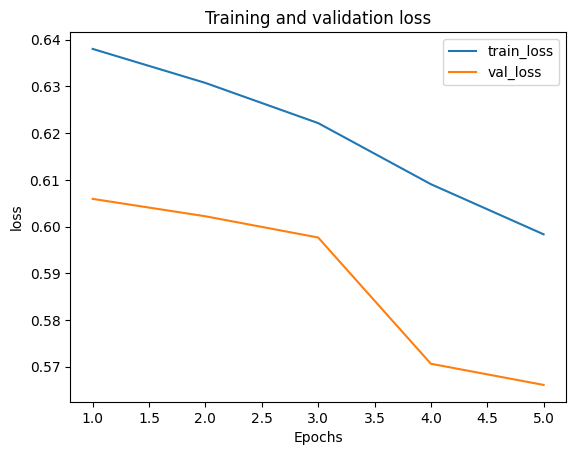

In [27]:
plot_epochMetric(history,'loss')